In [25]:
import os, sys, math, gc
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from utils.utils import merge_eval_sold_on_df, sort_df_on_d, WRMSSE, RMSSE, _down_cast, data_preprocessing, diff_lists, log_status #create_submission_df
from utils.utils import customIter, parse_columns_to_string
from utils import constants

from utils.configure_logger import configure_logger
configure_logger()
from logging import getLogger
logger = getLogger(__name__)

import warnings
warnings.simplefilter("ignore")

In [26]:
DATA_BASE_PATH = constants.DATA_BASE_PATH #'../data/m5-forecasting-accuracy/'
DATA_BASE_PATH_UNCERTAINTY = constants.DATA_BASE_PATH_UNCERTAINTY #'../data/m5-forecasting-uncertainty/'
SALES_EVALUATION = constants.SALES_EVALUATION #'sales_train_evaluation.csv'
SALES_VALIDATION = constants.SALES_VALIDATION #'sales_train_validation.csv'
CALENDAR = constants.CALENDAR #'calendar.csv'
SAMPLE_SUBMISSION = constants.SAMPLE_SUBMISSION #'sample_submission.csv'
SELL_PRICES = constants.SELL_PRICES #'sell_prices.csv'

PRECOMPUTED_BASE_PATH = constants.PRECOMPUTED_BASE_PATH #'../data/uncertainty/features/'

DAYS: int = constants.DAYS #28
QUANTILES: int = constants.QUANTILES #[0.005, 0.025, 0.165, 0.25, 0.50, 0.75, 0.835, 0.975, 0.995]

AGG_LEVEL_COLUMNS = constants.AGG_LEVEL_COLUMNS
D_CROSS_VAL_START_LIST = constants.D_CROSS_VAL_START_LIST #[1802, 1830, 1858, 1886, 1914]

In [27]:
# read all data
sales_validation: pd.DataFrame = _down_cast(pd.read_csv(DATA_BASE_PATH + SALES_VALIDATION))
sales_evaluation: pd.DataFrame = _down_cast(pd.read_csv(DATA_BASE_PATH + SALES_EVALUATION))
calendar: pd.DataFrame = _down_cast(pd.read_csv(DATA_BASE_PATH + CALENDAR))
sample_submission: pd.DataFrame = _down_cast(pd.read_csv(DATA_BASE_PATH + SAMPLE_SUBMISSION))
sell_prices: pd.DataFrame = _down_cast(pd.read_csv(DATA_BASE_PATH + SELL_PRICES))

### Feature Engineering

#### Test Runs

In [8]:
# ~25 seconds
# 1830, 1858, 1886, 1914
def drop_days_after(df, day_threshold):
    columns_keep = [c for c in df.columns if c.split('_')[0] != 'd']
    columns_keep += [
        c for c in 
            [d for d in df.columns if d.split('_')[0] == 'd'] 
            if int(c.split('_')[1]) < day_threshold
    ]
    return df[columns_keep]

In [9]:
D_START_VAL = 1800
df, submission_idx = data_preprocessing(
    drop_days_after(sales_evaluation.iloc[:int(1000000)],
        day_threshold = D_START_VAL), 
    calendar, 
    sell_prices
)
df = df[(df.wm_yr_wk > df.release)]
df['id'] = df['id'].astype(str)

In [18]:
days_forecast = np.random.randint(low=1, high=DAYS+1, size = len(df))
pd.to_timedelta(days_forecast, unit='D')

In [24]:
# df.date + pd.DateOffset(days_forecast)

TimedeltaIndex([ '4 days', '12 days', '25 days', '20 days', '26 days',
                '11 days', '27 days', '19 days', '23 days',  '5 days',
                ...
                '12 days', '20 days',  '7 days',  '4 days',  '6 days',
                '11 days',  '1 days', '20 days', '17 days', '11 days'],
               dtype='timedelta64[ns]', length=43192576, freq=None)

In [95]:
@log_status
def compute_features(df: pd.DataFrame, group_columns, q: int = None):
    """
    Type of features computed:
     - autocorrelation_ - moving averages mean/std | ewm mean
     - autoquantiles_   - rolling sales quantiles
     - momentum_        - changes in price
    """
    feature_columns = []
    # feature_columns += ['sell_price']
    for c in ['id', 'state_id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'd', 'sold']:
        if c in df:
            feature_columns += [c]
    
    # precomputing
    df["index"] = df.index
    df["d_int"] = df["d"].apply(lambda x: int(x.split("_")[-1]))
    df["day"] = str(df.date.dt.day)
    
    # to use groupby only once, saves time
    df_grouped = df.groupby(group_columns)
    
    ################################################
    ############### AUTOCORRELATION ################
    ################################################
    PREFIX = 'auto_'
    logger.info('Computing autocorrelation features')
    # DIRECT LAGGED VALUES
    old_columns: set = set(df.columns)
    LAG_SHIFT: int = 28
    for lag in [1, 2, 7, 14, 21]:
        df[PREFIX + f"sold_{lag}"] = df_grouped["sold"].shift(lag+LAG_SHIFT) # 1-day lag
    feature_columns += list(set(df.columns) - old_columns)
    
    # MOVING AVERAGES MEAN
    old_columns: set = set(df.columns)
    for i in [7, 28, 56, 168]:
        df[PREFIX + f'sold_ma_{i}'] = df_grouped['sold'].transform(lambda x: x.shift(LAG_SHIFT).rolling(i).mean()).astype(np.float16)
        df[PREFIX + f'sold_ma_std_{i}'] = df_grouped['sold'].transform(lambda x: x.shift(LAG_SHIFT).rolling(i).std()).astype(np.float16)
    feature_columns += list(set(df.columns) - old_columns)
    
    # ROLLING QUANTILES
    PREFIX = 'autoquantiles_'
    old_columns: set = set(df.columns)
    for quantile in QUANTILES:
        for i in [28, 56, 168]:
            if i * quantile >= 2:
                df[PREFIX + f'sold_ma_{i}_{quantile}'] = df_grouped['sold'].transform(lambda x: x.shift(LAG_SHIFT).rolling(i).quantile(quantile)).astype(np.float16)
    feature_columns += list(set(df.columns) - old_columns)
    
    # # DIFFERENCES
    # old_columns = set(df.columns)
    # feature_columns += list(set(df.columns) - old_columns)
    
    ###############################################
    ############ PRICE AUTOCORRELATION ############ ## ONLY FOR LOWEST AGGREGATION LEVEL USABLE?
    ###############################################
    logger.info('Computing price autocorrelation features')
    # # DIRECT LAGGED VALUES
    # old_columns = set(df.columns)
    # feature_columns += list(set(df.columns) - old_columns)
    
    # # MOVING AVERAGES
    # old_columns = set(df.columns)
    # feature_columns += list(set(df.columns) - old_columns)
    
    # # EXPONENTIAL SMOOTHING AVERAGES
    # old_columns = set(df.columns)
    # feature_columns += list(set(df.columns) - old_columns)
    
    # PRICE DIFFERENCES
    PREFIX = 'momentum_'
    old_columns = set(df.columns)
    df[PREFIX + 'sell_price_w'] = df['sell_price'] / df.groupby(group_columns + ['wm_yr_wk'])['sell_price'].transform(lambda x: x.shift(1))
    df[PREFIX + 'sell_price_m'] = df['sell_price'] / df.groupby(group_columns + ['year', 'month'])['sell_price'].transform(lambda x: x.shift(1))
    df[PREFIX + 'sell_price_y'] = df['sell_price'] / df.groupby(group_columns + ['year'])['sell_price'].transform(lambda x: x.shift(1))
    feature_columns += list(set(df.columns) - old_columns)

    ################################################
    ############ PRODUCT CHARACTERISTICS ###########
    ################################################
    logger.info('Computing unconditional sold values')
    # UNCONDITIONAL SALES
    PREFIX = 'unconditional_'
    # old_columns = set(df.columns)
    # df['sold_mean'] = df.groupby(['id'])['sold'].transform(lambda x: x.mean())
    # df['sold_std'] = df.groupby(['id'])['sold'].transform(lambda x: x.std())
    # df['sold_max'] = df.groupby(['id'])['sold'].transform(lambda x: x.max())
    # feature_columns += list(set(df.columns) - old_columns)
    
    # old_columns = set(df.columns)    
    # icols =  [
    #     ['state_id'],
    #     ['store_id'],
    #     ['cat_id'],
    #     ['dept_id'],
    #     ['state_id', 'cat_id'],
    #     ['state_id', 'dept_id'],
    #     ['store_id', 'cat_id'],
    #     ['store_id', 'dept_id'],
    #     ['item_id'],
    #     ['item_id', 'state_id'],
    #     ['item_id', 'store_id']
    # ]
    # for col in icols:
    #     col_name = '_'+'_'.join(col)+'_'
    #     df[PREFIX + 'sold'+col_name+'median'] = df.groupby(col)['sold'].transform('median').astype(np.float16)
    #     df[PREFIX + 'sold'+col_name+'mean'] = df.groupby(col)['sold'].transform('mean').astype(np.float16)
    #     df[PREFIX + 'sold'+col_name+'std'] = df.groupby(col)['sold'].transform('std').astype(np.float16)
    # feature_columns += list(set(df.columns) - old_columns)

    ################################################
    ############## SEASONAL FEATURES ###############
    ################################################
    logger.info('Encoding date features to dummies')
    PREFIX = 'seasonal_'
    # WEEK / MONTH DUMMIES
    encode_columns = ['weekday', 'month']
    old_columns = set(df.columns)
    df = pd.get_dummies(df, columns = encode_columns, prefix=PREFIX, prefix_sep='')
    feature_columns += list(set(df.columns) - old_columns)
    
    # for day, no dummy encoding
    df['seasonal_d_int'] = df['d_int']
    feature_columns += ['seasonal_d_int']
    
    
    ################################################
    ############## TARGET ENGINEERING ##############
    ################################################
    # the forecasting period is 28 days. We do not want to do recursive forecasting or something similar. 
    # Instead, we pass the days of forecasting as a feature in the model
    # For the training data, this forecasting period is randomized
    # For the validation and evaluation period, these are of course fixed
    days_forecast = np.random.randint(low = 0, high=DAYS, size = len(df))
    d_time = pd.to_timedelta(days_forecast, unit='D').to_series()
    
    # for the validation set, we know the forecasting period. Specifically map these increasingly from 0 to DAYS-1
    # mapping_dict = {D_START_VAL+i:i for i in range(DAYS)}
    # def map_d_to_days_fwd(row):
    #     return mapping_dict.get(row['d'], row[''])
    # d_time = d_time.to_list()
    
    # # SHORT CHECK
    # print(True if 'd_int' in df.columns else False)
    
    # 'shift' sales
    temp_columns = ['sold', 'd', 'd_int']
    df_temp = df[temp_columns + ['date']]
    df_temp['date'] -= pd.to_timedelta(d_time)
    df_temp['days_fwd'] = pd.to_timedelta(d_time)
    df_temp['days_fwd'] = df_temp['days_fwd'].dt.days
    
    # reduce forecasting days also from d_int and date
    df_temp['d_int'] -= df_temp['days_fwd']
    df_temp['d'] = 'd_' + df_temp['d_int'].astype(str)
    feature_columns += ['days_fwd']
    
    # merge shifted sales back
    df = df.drop(temp_columns, axis=1)
    df = pd.merge(
        df,
        df_temp,
        on = 'date',
        how = 'right'
    )
    
    
    ############# RETURN FINAL RESULTS ############
    
    # return final results
    df = _down_cast(df)
    return df[feature_columns]

In [96]:
# total ~77 seconds
df['temp_id'] = 'temp_id'
agg_columns = ['temp_id']
agg_columns = ['cat_id', 'state_id']
agg_dict = {
    'sold': np.nansum,
    'sell_price': np.nanmean,
    'date': 'last',
    'weekday': 'last',
    'month': 'last',
    'year': 'last',
    'wm_yr_wk': 'last'
}
features = compute_features(
    df.groupby(agg_columns + ['d']).agg(agg_dict).reset_index(drop=False),
    agg_columns
)
features

2023-11-12 17:06:08 - compute_features - INFO - calling
2023-11-12 17:06:08 - __main__ - INFO - Computing autocorrelation features
2023-11-12 17:06:08 - __main__ - INFO - Computing price autocorrelation features
2023-11-12 17:06:08 - __main__ - INFO - Computing unconditional sold values
2023-11-12 17:06:08 - __main__ - INFO - Encoding date features to dummies


,state_id,cat_id,d,sold,auto_sold_7,auto_sold_2,auto_sold_14,auto_sold_21,auto_sold_1,auto_sold_ma_std_168,...,seasonal_Sunday,seasonal_12,seasonal_2,seasonal_1,seasonal_4,seasonal_11,seasonal_7,seasonal_10,seasonal_d_int,days_fwd
0,NaN,NaN,d_-16,8552.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26
1,CA,FOODS,d_74,7416.0,11744.0,8416.0,9840.0,10920.0,9488.0,2047.000,...,False,False,False,False,True,False,False,False,74.0,26
2,TX,FOODS,d_74,7416.0,7932.0,5800.0,6720.0,8568.0,5968.0,1407.000,...,False,False,False,False,True,False,False,False,74.0,26
3,WI,FOODS,d_74,7416.0,11288.0,8632.0,7780.0,9120.0,6820.0,1793.000,...,False,False,False,False,True,False,False,False,74.0,26
4,CA,HOBBIES,d_74,7416.0,1390.0,994.0,1195.0,1141.0,1041.0,245.375,...,False,False,False,False,True,False,False,False,74.0,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146543,TX,HOBBIES,d_979,1556.0,764.0,626.0,1180.0,835.0,692.0,170.875,...,False,False,False,False,False,False,False,True,979.0,20
146544,WI,HOBBIES,d_979,1556.0,558.0,461.0,797.0,578.0,497.0,168.375,...,False,False,False,False,False,False,False,True,979.0,20
146545,CA,HOUSEHOLD,d_979,1556.0,4648.0,3302.0,5276.0,3872.0,3724.0,819.500,...,False,False,False,False,False,False,False,True,979.0,20
146546,TX,HOUSEHOLD,d_979,1556.0,2888.0,2200.0,3056.0,2332.0,2308.0,528.500,...,False,False,False,False,False,False,False,True,979.0,20


In [84]:
features['d']

0         d_24
1         d_24
2         d_24
3         d_24
4         d_24
          ... 
146199     NaN
146200     NaN
146201     NaN
146202     NaN
146203     NaN
Name: d, Length: 146204, dtype: category
Categories (1817, object): ['d_10', 'd_100', 'd_1000', 'd_1001', ..., 'd_996', 'd_997', 'd_998', 'd_999']

In [ ]:


days_forecast = np.random.randint(low=1, high=DAYS+1, size = len(df))
pd.to_timedelta(days_forecast, unit='D')

# days_forecast = np.random.randint(low=1, high=DAYS+1, size = len(df))
# pd.to_timedelta(days_forecast, unit='D')

# # test for id grouping
# features = compute_features(df.copy(), ['id'])
# print(features.shape)


In [93]:
D_START_VAL=1800

<Axes: >

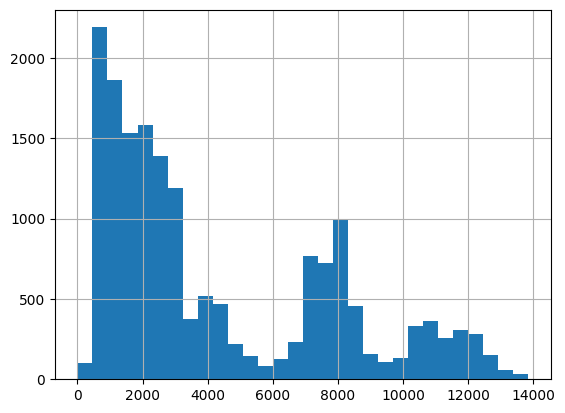

In [42]:
features['autoquantiles_sold_ma_30_0.75'].hist(bins=30)

In [13]:
# features[features['id'] == 'HOBBIES_1_008_CA_1_evaluation'][['sold', 'auto_sold_ma_7', 'auto_sold_ma_21', 'auto_sold_ma_60']].plot()

In [43]:
# spaces = 5
# for i in range(0,len(features.columns), spaces):
#     print('_'.join(list(features.columns)[i:i+spaces]))

state_id_cat_id_d_sold_auto_sold_14
auto_sold_1_auto_sold_21_auto_sold_7_auto_sold_2_auto_sold_ma_28
auto_sold_ma_std_180_auto_sold_ma_std_28_auto_sold_ma_std_60_auto_sold_ma_std_7_auto_sold_ma_7
auto_sold_ma_60_auto_sold_ma_180_autoquantiles_sold_ma_30_0.005_autoquantiles_sold_ma_30_0.75_autoquantiles_sold_ma_180_0.005
autoquantiles_sold_ma_180_0.995_autoquantiles_sold_ma_30_0.165_autoquantiles_sold_ma_60_0.025_autoquantiles_sold_ma_60_0.25_autoquantiles_sold_ma_60_0.975
autoquantiles_sold_ma_60_0.5_autoquantiles_sold_ma_30_0.25_autoquantiles_sold_ma_180_0.975_autoquantiles_sold_ma_180_0.835_autoquantiles_sold_ma_60_0.005
autoquantiles_sold_ma_180_0.25_autoquantiles_sold_ma_30_0.835_autoquantiles_sold_ma_60_0.995_autoquantiles_sold_ma_60_0.835_autoquantiles_sold_ma_180_0.5
autoquantiles_sold_ma_60_0.165_autoquantiles_sold_ma_30_0.5_autoquantiles_sold_ma_180_0.025_autoquantiles_sold_ma_30_0.975_autoquantiles_sold_ma_180_0.75
autoquantiles_sold_ma_60_0.75_autoquantiles_sold_ma_180_0.165

### Final Runs Feature Engineering for Validation and Evaluation

In [6]:
@log_status
def groupby_agglevel(df: pd.DataFrame, agg_columns: list, agg_dict: dict):
    return df.groupby(agg_columns).agg(agg_dict).reset_index(drop=False)

In [46]:
# 1830, 1858, 1886, 1914
D_CROSS_VAL_START: int = 1914

In [8]:
# # pivot initial dataframe and compute features/targets
# df_val, submission_idx_validation = data_preprocessing(sales_validation, calendar, sell_prices)
# df_val_after_release = df_val[(df_val.wm_yr_wk > df_val.release)]
# del df_val

# # set prediction values to nan values
# pred_index = df_val_after_release['d'].isin(D_CV_OOS)
# df_val_after_release.loc[pred_index, 'sold'] = np.nan
# del pred_index

In [10]:
for D_START_VAL in D_CROSS_VAL_START_LIST:
    logger.info(f'D_START_VAL: {D_START_VAL}')
    
    # pivot initial dataframe and compute features/targets
    df_val, submission_idx_validation = data_preprocessing(
        drop_days_after(sales_validation,
        day_threshold = D_START_VAL), 
        calendar, 
        sell_prices
    )
    df_val_after_release = df_val[(df_val.wm_yr_wk > df_val.release)]
    del df_val

    # set prediction values to nan values
    # pred_index = df_val_after_release['d'].isin(D_CV_OOS)
    # df_val_after_release.loc[pred_index, 'sold'] = np.nan
    # del pred_index

    TEST_RUN = False
    for agg_level in AGG_LEVEL_COLUMNS:
        agg_columns = AGG_LEVEL_COLUMNS[agg_level]
        # get data on aggregated level
        if len(agg_columns) == 0:
            df_val_after_release['temp_id'] = 'temp_id'
            agg_columns = ['temp_id']
        agg_dict = {
            'sold': np.nansum,
            'sell_price': np.nanmean,
            'date': 'last',
            'weekday': 'last',
            'month': 'last',
            'year': 'last',
            'wm_yr_wk': 'last'
        }
        features = compute_features(
            groupby_agglevel(df_val_after_release, agg_columns + ['d'], agg_dict),
            agg_columns
        )
        
        # to suitable format for .parquet
        for c in features.columns:
            if c not in ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'd', 'state_id']:
                features[c] = features[c].astype(np.float32)
        
        # format string and save file    
        agg_string = parse_columns_to_string(agg_columns)
        if not TEST_RUN:
            features.to_parquet(f'../data/uncertainty/fold_{int(D_START_VAL)}/features/' + f'features_val_{agg_string}.parquet', index=False)
            del features
        else:
            features.to_parquet(f'../data/uncertainty/fold_{int(D_START_VAL)}/features/' + f'/test/features_val_{agg_string}.parquet', index=False)
            
    if not TEST_RUN:
        del df_val_after_release

2023-08-20 17:01:22 - __main__ - INFO - D_START_VAL: 1802
2023-08-20 17:01:53 - groupby_agglevel - INFO - calling
2023-08-20 17:01:58 - compute_features - INFO - calling
2023-08-20 17:01:58 - __main__ - INFO - Computing autocorrelation features
2023-08-20 17:01:58 - __main__ - INFO - Computing price autocorrelation features
2023-08-20 17:01:58 - __main__ - INFO - Computing unconditional sold values
2023-08-20 17:01:58 - __main__ - INFO - Encoding date features to dummies
2023-08-20 17:01:58 - groupby_agglevel - INFO - calling
2023-08-20 17:02:02 - compute_features - INFO - calling
2023-08-20 17:02:02 - __main__ - INFO - Computing autocorrelation features
2023-08-20 17:02:02 - __main__ - INFO - Computing price autocorrelation features
2023-08-20 17:02:02 - __main__ - INFO - Computing unconditional sold values
2023-08-20 17:02:02 - __main__ - INFO - Encoding date features to dummies
2023-08-20 17:02:02 - groupby_agglevel - INFO - calling
2023-08-20 17:02:07 - compute_features - INFO - ca

In [ ]:
# # pivot initial dataframe and compute features/targets
# df_eval, submission_idx_validation = data_preprocessing(sales_evaluation, calendar, sell_prices)
# df_eval_after_release = df_eval[(df_eval.wm_yr_wk > df_eval.release)]
# del df_eval

# # set prediction values to nan values
# pred_index = df_eval_after_release['d'].isin(D_CV_OOS)
# df_eval_after_release.loc[pred_index, 'sold'] = np.nan
# del pred_index

In [36]:
# TEST_RUN = False
# for agg_level in AGG_LEVEL_COLUMNS:
#     agg_columns = AGG_LEVEL_COLUMNS[agg_level]
#     # get data on aggregated level
#     if len(agg_columns) == 0:
#         df_eval_after_release['temp_id'] = 'temp_id'
#         agg_columns = ['temp_id']
#     agg_dict = {
#         'sold': np.nansum,
#         'date': 'last',
#         'weekday': 'last',
#         'month': 'last'
#     }
#     features = compute_features(
#         groupby_agglevel(df_eval_after_release, agg_columns + ['d'], agg_dict),
#         agg_columns
#     )
    
#     # to suitable format for .parquet
#     for c in features.columns:
#         if c not in ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'd', 'state_id']:
#             features[c] = features[c].astype(np.float32)
        
#     # format string and save file
#     agg_string = parse_columns_to_string(agg_columns)
#     if not TEST_RUN:
#         features.to_parquet(PRECOMPUTED_BASE_PATH + f'features_eval_{agg_string}.parquet', index=False)
#         del features
#     else:
#         features.to_parquet(PRECOMPUTED_BASE_PATH + f'/test/features_eval_{agg_string}.parquet', index=False)
        
# if not TEST_RUN: 
#     del df_eval_after_release

2023-08-16 23:57:44 - groupby_agglevel - INFO - calling
2023-08-16 23:57:49 - compute_features - INFO - calling
2023-08-16 23:57:49 - __main__ - INFO - Computing autocorrelation features
2023-08-16 23:57:49 - __main__ - INFO - Computing price autocorrelation features
2023-08-16 23:57:49 - __main__ - INFO - Computing unconditional sold values
2023-08-16 23:57:49 - __main__ - INFO - Encoding date features to dummies
2023-08-16 23:57:49 - groupby_agglevel - INFO - calling
2023-08-16 23:57:52 - compute_features - INFO - calling
2023-08-16 23:57:52 - __main__ - INFO - Computing autocorrelation features
2023-08-16 23:57:52 - __main__ - INFO - Computing price autocorrelation features
2023-08-16 23:57:52 - __main__ - INFO - Computing unconditional sold values
2023-08-16 23:57:52 - __main__ - INFO - Encoding date features to dummies
2023-08-16 23:57:52 - groupby_agglevel - INFO - calling
2023-08-16 23:57:55 - compute_features - INFO - calling
2023-08-16 23:57:55 - __main__ - INFO - Computing au